<h2><center>Licenciatura en Tecnologías para la Información en Ciencias</center></h2>
<h2><center>Procesamiento de Imagenes</center></h2>
<h2><center>Tarea 4: Transformaciones Afines</center></h2>
<h2><center>Luis David Huante García</center></h2>
<h2><center>Matrícula: 420138905</center></h2>
<h2><center>A 23 de octubre de 2023</center></h2>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

1. Utilizando los conocimientos vistos en clase, realice la implementación de la transformación afín. El programa debe recibir una imagen en escala de grises y una matriz de transformación. Como salida, el programa debe regresar la imagen con la transformación afín aplicada.

In [ ]:
def get_cartesian_coordinate_matrix(N, M):
    return np.array([[[x, y, 1] for x in range(N)] for y in range(M)])

La función `get_cartesian_coordinate_matrix(N, M)` genera una matriz de dimensiones M x N, donde cada elemento es un vector [x, y, 1]. Aquí, x varía de 0 a N-1 y y varía de 0 a M-1, creando así una matriz de coordenadas cartesianas con un tercer elemento constante igual a 1.

In [ ]:
def center_cartesian_coordinates(cartesian_coord_matrix, Pc):
    centered_matrix = cartesian_coord_matrix - Pc
    return centered_matrix

La función `center_cartesian_coordinates` toma una matriz de coordenadas cartesianas (`cartesian_coord_matrix`) y un punto central (Pc), y resta este punto central de todas las coordenadas en la matriz, resultando en una nueva matriz de coordenadas centradas en Pc.

In [ ]:
def transform_cartesian_coordinates(Q, T):
    transformed_coords = np.dot(Q, T.T)
    return transformed_coords

La función `transform_cartesian_coordinates(Q, T)` transforma un conjunto de coordenadas cartesianas `Q` aplicando una transformación definida por la matriz `T`. Esto se hace mediante el producto punto entre `Q` y la transpuesta de `T`, resultando en las coordenadas transformadas.

In [ ]:
def get_minimum_box(Qp):
    x_coords = Qp[:,:,0]
    y_coords = Qp[:,:,1]
    left_upper_corner = (np.min(x_coords), np.max(y_coords))
    right_lower_corner = (np.max(x_coords), np.min(y_coords))
    return left_upper_corner, right_lower_corner

La función `get_minimum_box`(`Qp`) calcula y devuelve las esquinas superior izquierda e inferior derecha de la caja  que encierra los puntos en `Qp`, utilizando las coordenadas x e y mínimas y máximas.

2. La imagen de salida de la transformación afín tendrá puntos faltantes. Para resolver este problema se deben cubrir utilizando el procedimiento de interpolación bilineal.

In [ ]:
def bilinear_interpolation(x, y, N, M, img):
    if x < 0 or x >= N-1 or y < 0 or y >= M-1:
        return 0

    x1, y1 = int(x), int(y)
    x2, y2 = x1 + 1, y1 + 1

    A = img[y1, x1]
    B = img[y1, x2]
    C = img[y2, x1]
    D = img[y2, x2]

    return A * (x2 - x) * (y2 - y) + B * (x - x1) * (y2 - y) + C * (x2 - x) * (y - y1) + D * (x - x1) * (y - y1)

La función `bilinear_interpolation`calcula el valor interpolado en una posición (x, y) en una imagen img de tamaño N x M. Si (x, y) está fuera de límites, retorna 0. Utiliza los cuatro píxeles adyacentes para calcular el valor interpolado basándose en sus distancias ponderadas a (x, y).

In [ ]:
def affine_transformation(img, T):
    # Número de filas y columnas
    M, N = img.shape[:2]

    # Centro de la matriz/imagen
    Pc = np.array([(N-1)/2, (M-1)/2, 1])

    # Obtenemos la matriz de coordenadas cartesianas de 0 a x y 0 a y
    A = get_cartesian_coordinate_matrix(N, M)

    # Movemos las coordenadas al centro del eje
    Q = center_cartesian_coordinates(cartesian_coord_matrix=A, Pc=Pc)

    # Aplicamos la matriz de transformación afín a las coordenadas centradas
    Qp = transform_cartesian_coordinates(Q=Q, T=T)

    # Obtener las esquinas para usar en la imagen transformada
    left_upper_corner, right_lower_corner = get_minimum_box(Qp=Qp)

    # Transformación inversa
    invT = np.linalg.inv(T)

    # Coordenadas horizontales y verticales
    horizontal = np.arange(left_upper_corner[0], right_lower_corner[0] + 1)
    vertical = np.arange(left_upper_corner[1], right_lower_corner[1] - 1, -1)

    # Imagen transformada
    transformed_img = np.zeros((len(vertical), len(horizontal)))

    for ivp, ihp in np.ndindex(transformed_img.shape):
        # Convertimos al sistema de coordenadas de la imagen
        x, y = horizontal[ihp], vertical[ivp]

        # Se encuentra la fila y columna correspondiente de la matriz haciendo la transformación inversa
        fih, fiv, _ = np.matmul(invT, np.array([x, y, 1]))
        fih_np, fiv_np, _ = np.array([0, M-1, 0]) + ((np.array([fih, fiv, 1]) + np.array([Pc[0], Pc[1], 0])) * np.array([1, -1, 1]))

        # Realizamos interpolación bilineal
        transformed_img[ivp, ihp] = bilinear_interpolation(fih_np, fiv_np, N, M, img)

    return transformed_img

La función `affine_transformation` aplica la transformación afín, definida por la matriz T, a una imagen img. Calcula un nuevo conjunto de coordenadas para cada píxel, determina el tamaño de la imagen transformada, realiza la transformación inversa para mapear los píxeles en el nuevo espacio, y utiliza la interpolación bilineal para asignar valores de píxeles en la imagen transformada.

## Matriz de rotación

In [ ]:
def create_rotation_matrix(angle, center):
    angle_rad = np.deg2rad(angle)
    cos_val, sin_val = np.cos(angle_rad), np.sin(angle_rad)

    # Matriz de traslación
    translation_to_origin = np.array([
        [1, 0, -center[0]],
        [0, 1, -center[1]],
        [0, 0, 1]
    ])

    # Matriz de rotación alrededor del origen
    rotation = np.array([
        [cos_val, -sin_val, 0],
        [sin_val, cos_val, 0],
        [0, 0, 1]
    ])

    # Matriz para regresar el origen al centro de rotación
    translation_back = np.array([
        [1, 0, center[0]],
        [0, 1, center[1]],
        [0, 0, 1]
    ])

    # Matriz combinada
    return np.dot(np.dot(translation_back, rotation), translation_to_origin)

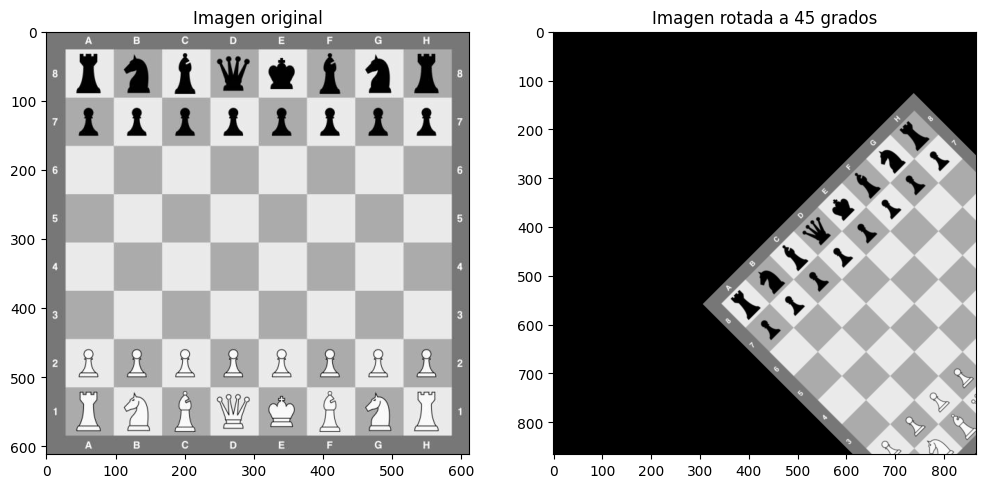

In [ ]:
# Imagen de ejemplo
sample_image = cv2.imread('chess.jpg', cv2.IMREAD_GRAYSCALE)

# Matriz de rotación
rotation_angle = 45  # Grados
image_center = (sample_image.shape[1] / 2, sample_image.shape[0] / 2)
rotation_matrix = create_rotation_matrix(rotation_angle, image_center)

# Aplicación de la transformación afín de rotación a la imagen
rotated_image = affine_transformation(sample_image, rotation_matrix)

# Visualización de la imagen original y rotada
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title('Imagen original')
plt.subplot(1, 2, 2)
plt.imshow(rotated_image, cmap='gray')
plt.title(f'Imagen rotada a {rotation_angle} grados')
plt.show()